# Severstal : Steel Defect Detection
https://www.kaggle.com/c/severstal-steel-defect-detection/data

Learning U Nets with Tensorflow using Severstal Dataset from Keggle competition

In [52]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import os, sys
import csv
from matplotlib import pyplot as plt
import PIL

In [4]:
test_path = 'test_images'
train_path = 'train_images'

In [41]:
def get_filenames(mypath): 
    return [mypath + '/' + f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

In [6]:
test_filenames = get_filenames(test_path)
train_filenames = get_filenames(train_path) 

In [7]:
print(len(test_filenames))

1801


In [12]:
print(len(train_filenames))

12568


Get training labels / annotations

In [13]:
defects = { r[0] : r[1] for r in [row for row in csv.reader(open('train.csv', 'r'))][1:]}

In [14]:
defects_df = pd.read_csv('train.csv')
defects_df['ImageId'] = defects_df['ImageId_ClassId'].apply(lambda x : x.split('_')[0])
defects_df['ClassId'] = defects_df['ImageId_ClassId'].apply(lambda x : x.split('_')[1])

In [15]:
defects_df.set_index('ImageId_ClassId', inplace=True)

In [16]:
defects_df.head(5)

,EncodedPixels,ImageId,ClassId
ImageId_ClassId,,,
0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1
0002cc93b.jpg_2,NaN,0002cc93b.jpg,2
0002cc93b.jpg_3,NaN,0002cc93b.jpg,3
0002cc93b.jpg_4,NaN,0002cc93b.jpg,4
00031f466.jpg_1,NaN,00031f466.jpg,1


## Display some train example data

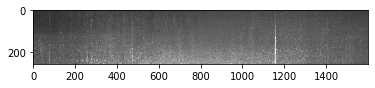

In [17]:
img = cv2.imread(train_path + '/' + defects_df.loc['0007a71bf.jpg_3', 'ImageId'])
#cv2.imshow('train', img)
plt.imshow(img)

In [18]:
img[0]

array([[47, 47, 47],
       [49, 49, 49],
       [49, 49, 49],
       ...,
       [65, 65, 65],
       [67, 67, 67],
       [63, 63, 63]], dtype=uint8)

https://www.kaggle.com/titericz/building-and-visualizing-masks

Run-length encoding (RLE) is a very simple form of lossless data compression in which runs of data (sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run. 

In [19]:
'''
This function is an rle to mask converter.
You supply the rle string for one mask, along with it's height and width
from the solutions for stage1 and it will return the mask.
'''
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

In [16]:
img.shape

(256, 1600, 3)

In [20]:
rleToMask = rle2mask(str(defects_df.loc['0007a71bf.jpg_3', 'EncodedPixels']), img.shape)

In [21]:
print(rleToMask.shape)

(256, 1600)


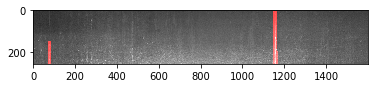

In [22]:
img[rleToMask==1,0] = 255
plt.imshow(img)

## Number of defects per class

In [23]:
defects_df['EncodedPixels'].notnull()

ImageId_ClassId
0002cc93b.jpg_1     True
0002cc93b.jpg_2    False
0002cc93b.jpg_3    False
0002cc93b.jpg_4    False
00031f466.jpg_1    False
                   ...  
ffff4eaa8.jpg_4    False
ffffd67df.jpg_1    False
ffffd67df.jpg_2    False
ffffd67df.jpg_3     True
ffffd67df.jpg_4    False
Name: EncodedPixels, Length: 50272, dtype: bool

In [24]:
defects_df[['ClassId', 'EncodedPixels']][defects_df['EncodedPixels'].notnull()].groupby(['ClassId']).count()

,EncodedPixels
ClassId,
1,897
2,247
3,5150
4,801


Most common deffect class is 3, then 1, followed by 4 and 2

Are there images with multiple defects? 

In [25]:
image_by_defects = defects_df[['ImageId', 'EncodedPixels']][defects_df['EncodedPixels'].notnull()].groupby(['ImageId']).count().sort_values('EncodedPixels', ascending=False)

In [26]:
image_by_defects.head()

,EncodedPixels
ImageId,
ef24da2ba.jpg,3
db4867ee8.jpg,3
84865746c.jpg,2
5665ada1b.jpg,2
eb44ad79d.jpg,2


In [30]:
image = 'ef24da2ba.jpg' 
df_ = defects_df[defects_df['ImageId'] == image]
df_.head()

,EncodedPixels,ImageId,ClassId
ImageId_ClassId,,,
ef24da2ba.jpg_1,366699 32 366955 32 367210 33 367466 33 367722...,ef24da2ba.jpg,1
ef24da2ba.jpg_2,366338 17 366594 50 366850 82 367106 99 367362...,ef24da2ba.jpg,2
ef24da2ba.jpg_3,178369 64 178498 191 178690 255 178946 255 179...,ef24da2ba.jpg,3
ef24da2ba.jpg_4,NaN,ef24da2ba.jpg,4


In [31]:
# 1 - red, 2 - yellow, 3- green , 4 - blue
colors = {1 : [255, 0, 0], 2: [255, 255, 0], 3: [0, 255, 0], 4: [0, 0, 255]}

## Example of an image with 3 defect classes

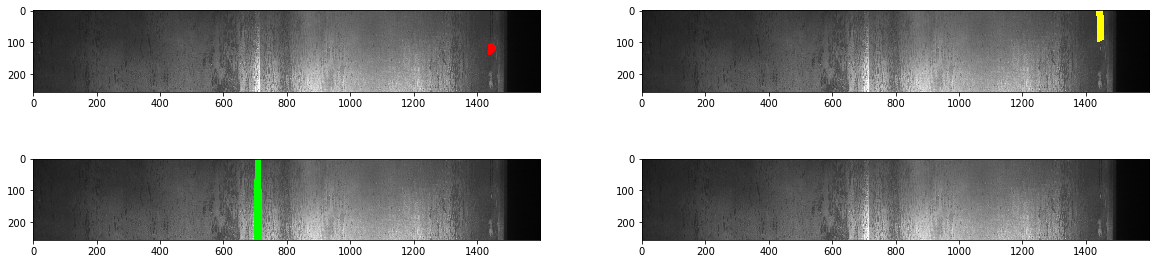

In [32]:
rows=2
columns=2
fig=plt.figure(figsize=(20, 5))
for c_id in range(1, 4+1):
    fig.add_subplot(rows, columns, c_id)
    img = cv2.imread(train_path + '/' + image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    encoded_pixels = df_.loc['{0}_{1}'.format(image, c_id), 'EncodedPixels']
    if str(encoded_pixels) != 'nan':
        rleToMask = rle2mask(encoded_pixels, img.shape)
        img[rleToMask==1] = colors[c_id]
    plt.imshow(img) 
plt.show()

Some more examples

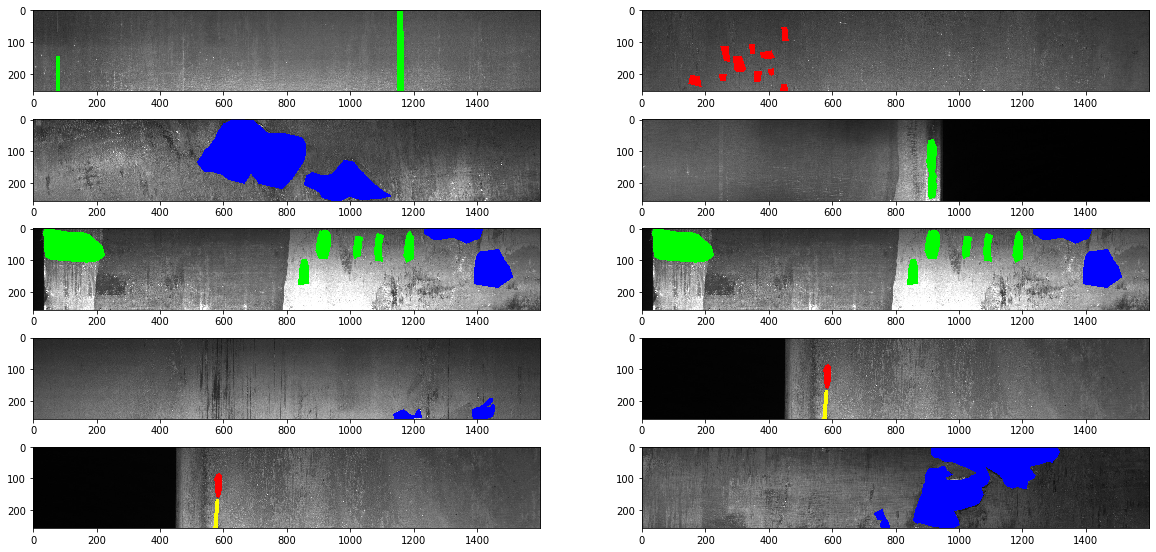

In [23]:
fig=plt.figure(figsize=(20,100))
columns = 2
rows = 50
train = defects_df[defects_df['EncodedPixels'].notnull()]
for i in range(1, 10+1):
    fig.add_subplot(rows, columns, i)
    
    fn = train['ImageId'].iloc[i]
    img = cv2.imread( 'train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    df = train[train['ImageId'] == fn].reset_index()
    for j in range(len(df)):
        mask = rle2mask( df['EncodedPixels'].iloc[j], img.shape  )
        img[mask==1] = colors[int(df['ClassId'].iloc[j])]
    
    plt.imshow(img)
plt.show()

In [33]:
## Unique images with defects
no_defects = defects_df[defects_df['EncodedPixels'].notnull()]
len(no_defects['ImageId'].unique())

6666

In [29]:
len(defects_df['ImageId'].unique())

12568

In [30]:
##save the mapping masks in separate folder

In [34]:
test = np.load('train_masks/ef24da2ba.jpg.npy')

In [35]:
test.shape

(256, 1600)

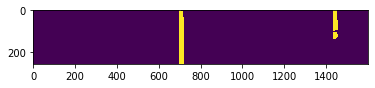

In [36]:
plt.imshow(test)

In [37]:
img.shape

(256, 1600, 3)

## Load data using tf.data
https://www.tensorflow.org/tutorials/load_data/images

In [38]:
IMG_WIDTH = 1600
IMG_HEIGHT = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [46]:
list_ds = tf.data.Dataset.list_files('train_images/*.jpg')

In [43]:
def get_npy_filepath(file_path):
    # file_path - input Tensor
    # convert the path to a list of path components
    #parts = str(file_path).replace('\'', '').split('/')
    print(file_path)
    parts = tf.strings.split(file_path, '/')
    # The second to last is the class-directory
    try:
        #npy_filename = f"{str(parts[1].numpy(), 'utf-8')}.npy"
        npy_filename = tf.strings.join(['train_masks/', [parts[1]], '.npy'])
        #print(npy_filename)
        #return tf.keras.utils.get_file(f"train_masks/{npy_filename}")
        return npy_filename
    except IndexError:
        print(file_path)
        print(parts)

In [44]:
def read_npy_file(item):
    data = np.load(item)
    return data.astype(np.float32)

#file_list = tf.data.Dataset.list_files('train_masks/*.npy')
#file_list = list(data_dir.glob('train_masks/*.npy'))
file_list = ['train_masks/'+f for f in os.listdir('train_masks/') if os.path.isfile(os.path.join('train_masks/', f))]
dataset = tf.data.Dataset.from_tensor_slices(file_list)

dataset = dataset.map(
        lambda item: tf.py_function(read_npy_file, [item], [tf.float32,]), num_parallel_calls=AUTOTUNE)

NameError: name 'AUTOTUNE' is not defined

In [ ]:
for f in list_ds.take(1):
    print(f.numpy())
    print(get_npy_filepath(f))

In [228]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [229]:
def decode_mask(mask):
    mask = tf.strings.to_number(mask, out_type=tf.dtypes.float32)
    return mask

In [230]:
def process_path(file_path):
    #mask = tf.io.read_file(get_npy_filepath(file_path))
    #mask = decode_mask(mask)
    #mask = tf.cast(mask, 'int32')
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img
    #, mask

In [231]:
type(list_ds)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

In [238]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(lambda x: process_path(x), num_parallel_calls=AUTOTUNE)

In [239]:
train = tf.data.Dataset.zip((labeled_ds, dataset)) 

In [39]:
for f in dataset.take(3):
    print(f)

NameError: name 'dataset' is not defined

In [202]:
train.element_spec

(TensorSpec(shape=(256, 1600, 3), dtype=tf.float32, name=None),
 (TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),))

## Image segmentation with U-Net

In [204]:
import pix2pix

In [205]:
#define output channels - number of possible classes that one pixel can be assigned to (0 for no defect)
OUTPUT_CHANNELS = 4

In [206]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img.shape, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [207]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [208]:
def unet_model(output_channels, img_shape):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=img_shape)
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [209]:
model = unet_model(OUTPUT_CHANNELS, img_shape= [IMG_HEIGHT,IMG_WIDTH, 3])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [176]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [177]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [45]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        print(type(display_list[i]))
        print(display_list[i].shape)
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

In [223]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    print(sample_mask)


(<tf.Tensor: id=8581960, shape=(256, 1600), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,)


In [43]:
dataset = tf.data.TFRecordDataset(filenames = get_filenames('tfrecord/'))

raw_example = next(iter( dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())


In [54]:
img_raw = parsed.features.feature['img_raw']
img_masks = parsed.features.feature['img_masks']

AttributeError: numpy

In [53]:
def bytes_to_img(image_data):
    PIL.Image.frombytes('RGBA', (128,128), image_data, 'raw')
bytes_to_img(img_raw)

TypeError: a bytes-like object is required, not 'Feature'

<class 'tensorflow.core.example.feature_pb2.Feature'>


AttributeError: shape

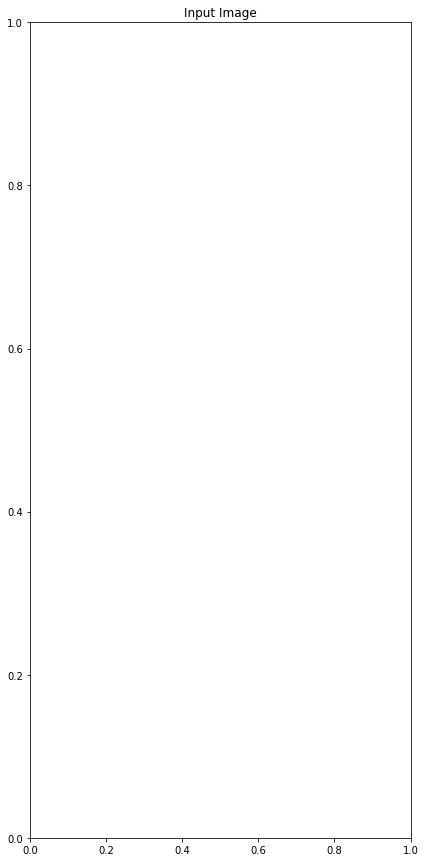

In [46]:
display([img_raw, img_masks])